In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier, plot_importance, DMatrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

train_data = pd.read_csv("train.csv", encoding="ansi", dtype={"APC_1ST_AGE":object, "RFM_R":object, "REBUY_TIMES_CNT":object})

### 前置作業

In [2]:
train_data["Y1"] = train_data["Y1"].map({"N":0, "Y":1})
train_data["GENDER"] = train_data["GENDER"].map({"F":0, "M":1})  # Y1轉成數字以利後面操作、性別是我覺得唯一能轉換的類別資料
'''
# train_data["GENDER"] = train_data["GENDER"].fillna(pd.Series(np.random.choice([0,1], size=len(train_data.index))))
>> Generate random integers from [0,1]
'''

predict = train_data["Y1"]  # 原先資料中的結果
raw_drop = train_data.drop(["Y1"], axis=1)  #除了結果外的資料 
# train_data[predict=="N"].describe(include="all").iloc[:, 59:75]
# train_data[predict=="Y"].describe(include="all").iloc[:, 59:75]

###  觀察資料分布

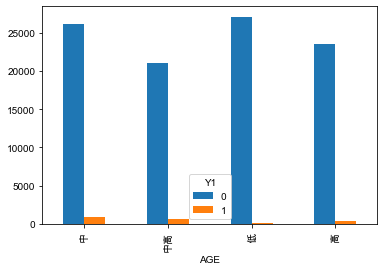

In [3]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial Unicode MS'
df = train_data.groupby(["AGE", "Y1"])["CUS_ID"].count().unstack()
df.plot(kind="bar", secondary_y="Y")

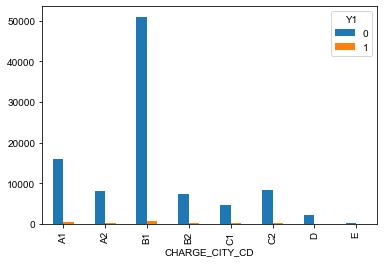

In [4]:
%matplotlib inline
df = train_data.groupby(["CHARGE_CITY_CD", "Y1"])["CUS_ID"].count().unstack()
df.plot(kind="bar", secondary_y="Y")

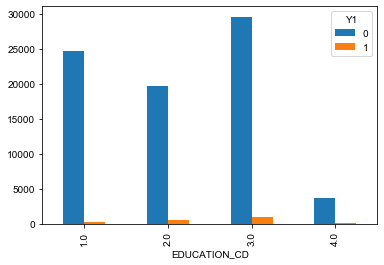

In [5]:
%matplotlib inline
df = train_data.groupby(["EDUCATION_CD", "Y1"])["CUS_ID"].count().unstack()
df.plot(kind="bar", secondary_y="Y")

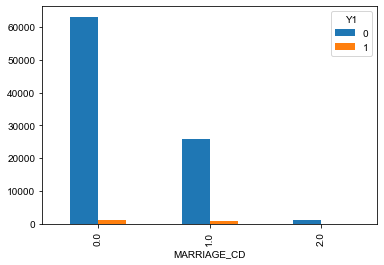

In [6]:
%matplotlib inline
df = train_data.groupby(["MARRIAGE_CD", "Y1"])["CUS_ID"].count().unstack()
df.plot(kind="bar", secondary_y="Y")

_首次擔任被保人年齡_

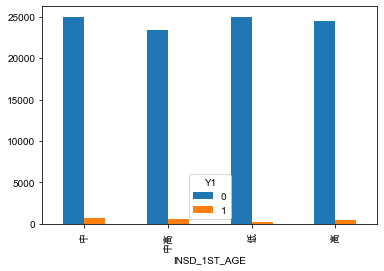

In [7]:
%matplotlib inline
df = train_data.groupby(["INSD_1ST_AGE", "Y1"])["CUS_ID"].count().unstack()
df.plot(kind="bar", secondary_y="Y")

+ [ ] 另一種資料前處理方式

In [ ]:
train_data = train_data.loc[:, :-1]
index = train_data[train_data["GENDER"].isna()==True].index
train_data = train_data.dropna(subset=["GENDER"])

# train_data.fillna(1, inplace=True)
# train_data = pd.get_dummies(train_data, dtype=float)
# train_data.fillna(method="ffill")

In [ ]:
predict.drop(index = index, inplace=True)
train_data = train_data.astype("float")
train_data.info()

> Nan值的處理
>> 後來直接懶得研究

In [ ]:
train_data = train_data.dropna(axis=1)
train_data.info(verbose=1, null_counts=True)

In [ ]:
train_data = train_data.fillna(0)
train_data = train_data.astype("category")
train_data.tail()

- [ ] 原本想將特徵進行降維

In [ ]:
pca_reduced_data = PCA(n_components=2, svd_solver="randomized").fit_transform(train_data.iloc[:, :-2])  # 轉換到二維空間上
# iso_reduced_data = Isomap().fit_transform(train_data)  # 使用這個方法直接死機

%matplotlib inline
plt.scatter(pca_reduced_data[:, 0], pca_reduced_data[:, 1])

### Preprocessing

In [8]:
train_data = pd.get_dummies(train_data, dtype="float")  # 將所有特徵進行One-hot Encoding
train_data = train_data.astype("float")  # 統一資料型態不然一直跳出error
train_data = train_data.drop(["Y1"], axis=1)  # 移除Y1這一行
train_data.fillna(0, inplace=True)  # 把NA值直接補0

sss = StratifiedShuffleSplit(test_size=0.25, train_size=0.75)  # 比起train_test_split，它可以隨機抽取並劃分資料
for _train, _test in sss.split(train_data, predict):
    X_train, X_test = train_data[train_data.index.isin(_train)], train_data[train_data.index.isin(_test)]
    Y_train, Y_test = predict[predict.index.isin(_train)], predict[predict.index.isin(_test)]

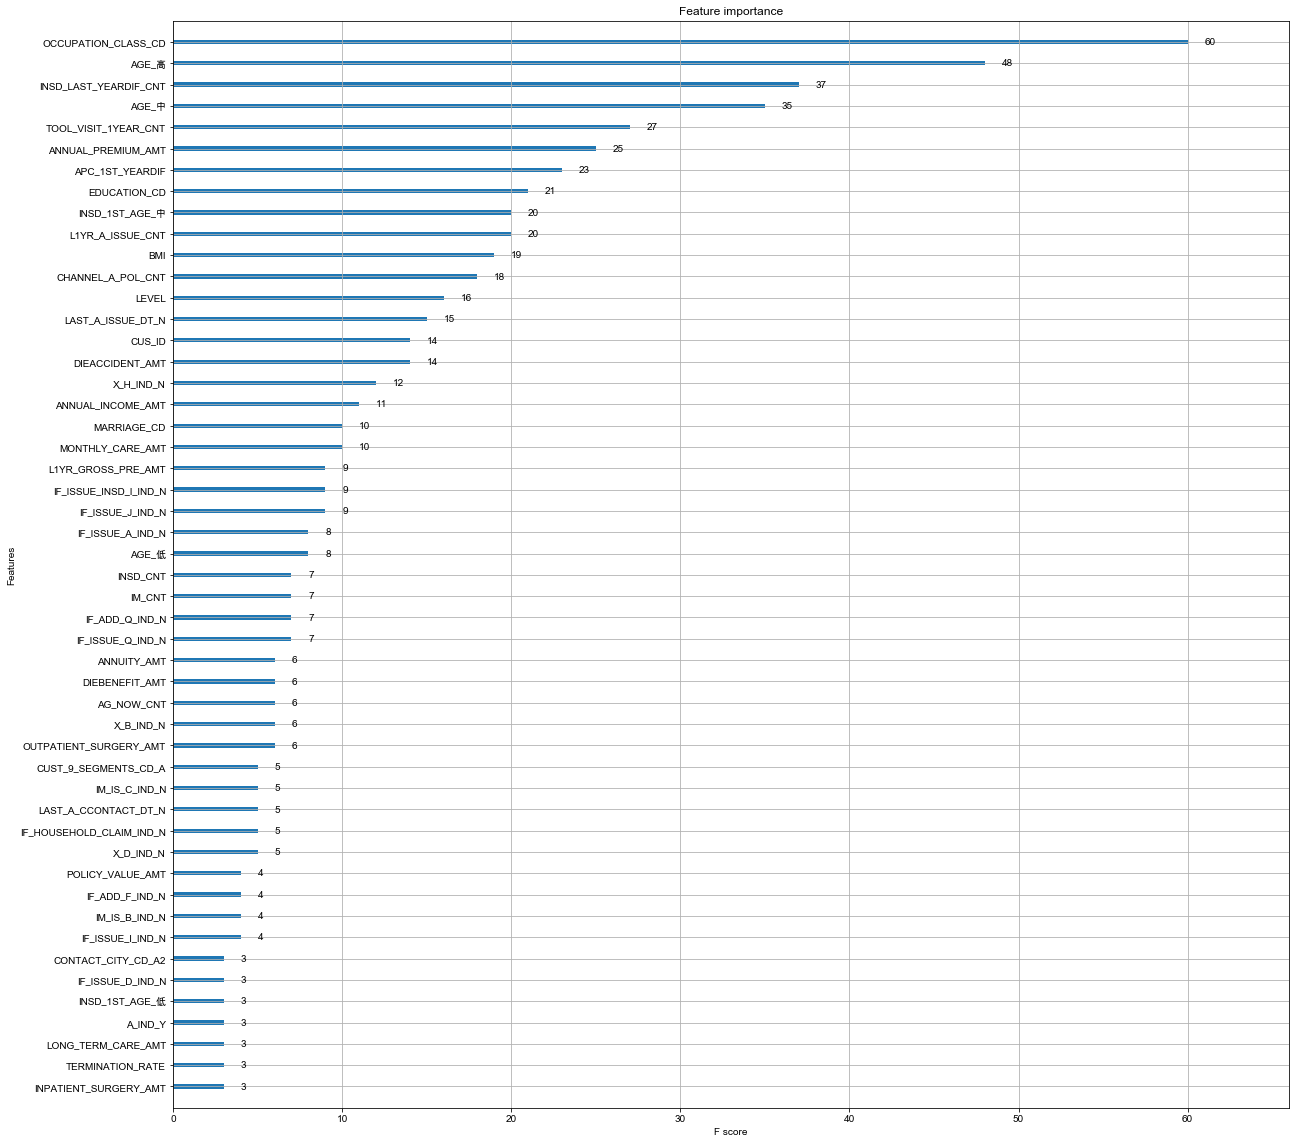

In [9]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial Unicode MS'  # 沒它顯示不出中文
xgbc = XGBClassifier(n_jobs=-1)
xgbc.fit(X_train, Y_train)

fig, ax = plt.subplots(figsize=(20,20))
plot_importance(xgbc, ax=ax, max_num_features=50)  # 顯示前五十名的結果

In [10]:
train_data = train_data.set_index("CUS_ID")  # 把ID設為索引標籤，有利於最後資料上傳

## 觀察相關性

In [ ]:
%matplotlib inline
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr(), cbar=False, annot=True, fmt='.2f')
## 特徵太多會跑超久跑不出來哦

## 模型選擇

In [12]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
roc_auc_score(Y_test, gnb.predict_proba(X_test)[:, 1])

NameError: name 'GaussianNB' is not defined

In [16]:
log = LogisticRegression(solver="liblinear")
log.fit(X_train, Y_train)
roc_auc_score(Y_test, log.predict_proba(X_test)[:, 1])

0.48773314285714287

In [14]:
cross_val_score(log, train_data, predict, cv=sss, scoring="roc_auc", n_jobs=-1)

array([0.80962176, 0.81612196, 0.8113031 , 0.80790237, 0.80512776,
       0.8154138 , 0.81411559, 0.81666269, 0.8128682 , 0.81416833])

## 上傳預測資料

In [ ]:
test_data = pd.read_csv("test.csv", encoding="ansi", dtype={"APC_1ST_AGE":object, "RFM_R":object, "REBUY_TIMES_CNT":object})
test_data["GENDER"] = test_data["GENDER"].map({"F":0, "M":1})
test_data = test_data.set_index("CUS_ID")
test_data = pd.get_dummies(test_data, dtype="float")
''''''
test_data = test_data[features]
test_data.fillna(0, inplace=True)
''''''
test_data = test_data.astype("float")

In [ ]:
log_pred = pd.Series(log.predict(test_data), name="Ypred")
upload = pd.concat([pd.Series(test_data.index), log_pred], axis=1).set_index("CUS_ID")
upload.to_csv("upload_0922_1.csv")